In [1]:
## NEED TO RUN THIS TO GET CHOLMOD TO WORK
import ctypes

CUDA_LIB = "/share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib"
OPENBLAS = "/share/software/user/open/openblas/0.3.20/lib"
SUITESPARSE = "/share/software/user/open/suitesparse/7.4.0/lib64"

libs_to_load = [
    f"{OPENBLAS}/libopenblas.so.0",
    f"{CUDA_LIB}/libnvrtc.so.12",
    f"{CUDA_LIB}/libcublas.so.12",
    f"{CUDA_LIB}/libcublasLt.so.12",
    f"{CUDA_LIB}/libnvrtc-builtins.so.12.2",
    f"{SUITESPARSE}/libcholmod.so.5",
]

# Load each library with global visibility
for lib in libs_to_load:
    print(f"Loading {lib} ...")
    ctypes.CDLL(lib, mode=ctypes.RTLD_GLOBAL)

# Import sksparse safely
import sksparse.cholmod as cholmod
print("✓ sksparse imported successfully")


Loading /share/software/user/open/openblas/0.3.20/lib/libopenblas.so.0 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublas.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libcublasLt.so.12 ...
Loading /share/software/user/open/cuda/12.2.0/targets/x86_64-linux/lib/libnvrtc-builtins.so.12.2 ...
Loading /share/software/user/open/suitesparse/7.4.0/lib64/libcholmod.so.5 ...
✓ sksparse imported successfully


In [2]:
import cvxpy as cp
import numpy as np
import time
import torch
import h5py
import copy
from zap.admm import ADMMSolver
from zap.resource_opt.nu_opt_bridge import NUOptBridge
from zap.conic.cone_utils import get_standard_conic_problem
import scipy.sparse as sp
from experiments.resource_opt_solve.benchmarks.nu_opt_benchmark import NUOptBenchmarkSet
import matplotlib.pyplot as plt


/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/diffcp/cone_program.py:207: SyntaxWarning: invalid escape sequence '\i'
  """Solves a cone program, returns its derivative as an abstract linear map.
/home/groups/ramr/akshay81/poetry_cache/virtualenvs/zap-eFcx8M23-py3.12/lib/python3.12/site-packages/pypsa/linopf.py:1253: SyntaxWarning: invalid escape sequence '\ '
  n.objective_f.write("\ LOPF \n\nmin\nobj:\n")


In [3]:
## Clarabel
## m = 20000, n = 10000, base_seed = 42
## (CVXPY) Jul 01 07:26:27 PM: Problem status: optimal
## (CVXPY) Jul 01 07:26:27 PM: Optimal value: -3.331e+04
## (CVXPY) Jul 01 07:26:27 PM: Compilation took 4.493e-02 seconds
## (CVXPY) Jul 01 07:26:27 PM: Solver (including time spent in interface) took 3.467e+03 seconds

## MOSEK (default accuracy)
## m = 200000, n = 100000, base_seed = 42
## (CVXPY) Jul 01 10:31:08 PM: Problem status: optimal
## (CVXPY) Jul 01 10:31:08 PM: Optimal value: -3.310e+05
## (CVXPY) Jul 01 10:31:08 PM: Compilation took 6.808e-01 seconds
## (CVXPY) Jul 01 10:31:08 PM: Solver (including time spent in interface) took 3.660e+03 seconds

## MOSEK (low accuracy, 1e-3)
## m = 200000, n = 100000, base_seed = 42
## Solve Time: 2348 seconds
m = 20000
n = 10000
avg_route_length = 10

benchmark = NUOptBenchmarkSet(num_problems=1, 
        m=m, 
        n=n, 
        avg_route_length=avg_route_length, 
        capacity_range=(0.1,1), 
        link_congest_num_frac=0.001,
        link_congest_util_frac=0.1,
        congested_capacity_scale=1,
        base_seed=42)
for i, prob in enumerate(benchmark):
        problem = prob
mosek_params={
        'MSK_DPAR_INTPNT_CO_TOL_PFEAS': 1e-3,     # Primal feasibility
        'MSK_DPAR_INTPNT_CO_TOL_DFEAS': 1e-3,     # Dual feasibility  
        'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-3,   # Relative gap
}
# problem.solve(solver=cp.SCS, verbose=True, use_indirect=True, eps=1e-3)
problem.solve(solver=cp.MOSEK, verbose=True, mosek_params={})
# problem.solve(solver=cp.CLARABEL, verbose=True)
ref_obj = -problem.value

R, capacities, w, linear_flow_idxs = benchmark.get_data(0)
nu_opt_params = {
    "R": R,
    "capacities": capacities,
    "w": w,
    "lin_device_idxs": linear_flow_idxs,
}

                                     CVXPY                                     
                                     v1.6.4                                    
(CVXPY) Jul 25 01:58:07 PM: Your problem has 10000 variables, 30000 constraints, and 0 parameters.
(CVXPY) Jul 25 01:58:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 25 01:58:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 25 01:58:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 25 01:58:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 25 01:58:07 PM: Compiling problem (target solver=MOSE

In [18]:
## Save the problem data to run in Julia later
cone_params, data, cones = get_standard_conic_problem(problem, solver=cp.CLARABEL)

# Save to HDF5
with h5py.File('NUM_200k_seed42.h5', 'w') as f:
    # Handle sparse A matrix
    A_csr = cone_params['A'].tocsr()
    f['A_data'] = A_csr.data
    f['A_indices'] = A_csr.indices  
    f['A_indptr'] = A_csr.indptr
    f['A_shape'] = A_csr.shape
    
    # Dense arrays
    f['b'] = cone_params['b']
    f['c'] = cone_params['c']
    
    # Cone info
    f['cone_z'] = cone_params['K']['z']
    f['cone_l'] = cone_params['K']['l'] 
    f['cone_ep'] = cone_params['K']['ep']
    
    # Problem has no P matrix
    f['has_P'] = False

print(f"Saved problem: {len(cone_params['c'])} variables, {len(cone_params['b'])} constraints")
print(f"Cone structure: {cone_params['K']}")

Saved problem: 200000 variables, 600000 constraints
Cone structure: {'z': 0, 'l': 300000, 'q': [], 'ep': 100000, 's': []}


In [8]:
col_nnz = R.sum(axis=0)
row_nnz = R.sum(axis=1)

(array([ 106.,  613., 1566., 2333., 2388., 2202.,  528.,  195.,   49.,
          20.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

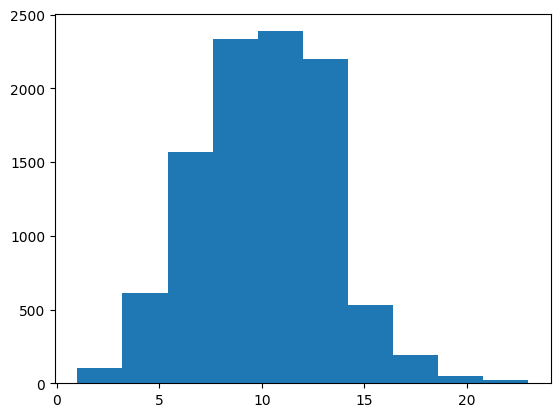

In [9]:
plt.hist(col_nnz.T)

(array([19980.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    20.]),
 array([   0. ,  105.7,  211.4,  317.1,  422.8,  528.5,  634.2,  739.9,
         845.6,  951.3, 1057. ]),
 <BarContainer object of 10 artists>)

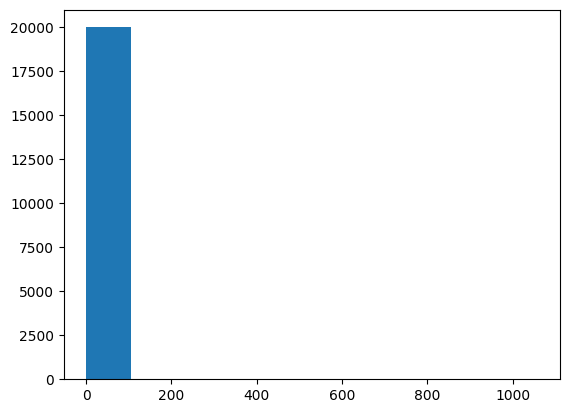

In [10]:
plt.hist(row_nnz)

(array([19851., 19994., 19951., 20028., 19918., 20083., 20002., 20064.,
        20057., 20052.]),
 array([0.10000419, 0.19000332, 0.28000245, 0.37000158, 0.46000071,
        0.54999984, 0.63999897, 0.7299981 , 0.81999723, 0.90999636,
        0.99999549]),
 <BarContainer object of 10 artists>)

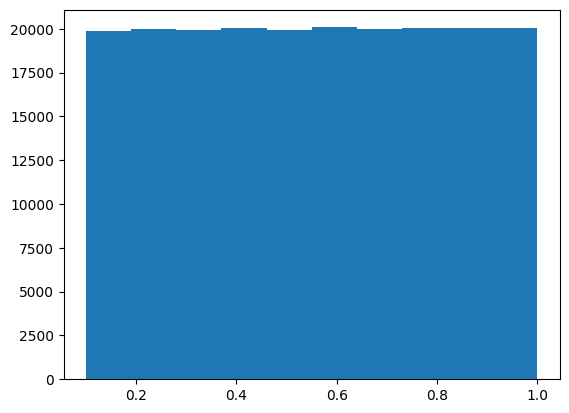

In [15]:
plt.hist(capacities)

In [16]:
grouping_params = {}
my_tuple = tuple(range(27)) + (100,)
grouping_params["variable_grouping_strategy"] = "discrete_terminal_groups"
# grouping_params["variable_grouping_bin_edges"] = my_tuple

nu_opt_bridge = NUOptBridge(nu_opt_params, grouping_params)
machine = "cuda"
dtype = torch.float32
admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in nu_opt_bridge.devices]
admm = ADMMSolver(
    machine=machine,
    dtype=dtype,
    atol=1e-9,
    rtol=1e-9,
    tau=2,
    alpha=1.6,
    num_iterations=1500
)
start_time = time.time()
solution_admm, history_admm = admm.solve(nu_opt_bridge.net, admm_devices, nu_opt_bridge.time_horizon)
end_time = time.time()
solve_time = end_time - start_time
obj_val = solution_admm.objective
print(f"Objective value: {obj_val}")
print(f"Time taken: {solve_time:.4f} seconds")

Did not converge. Ran for 1500 iterations.
Objective value: 68389.8203125
Time taken: 86.4588 seconds


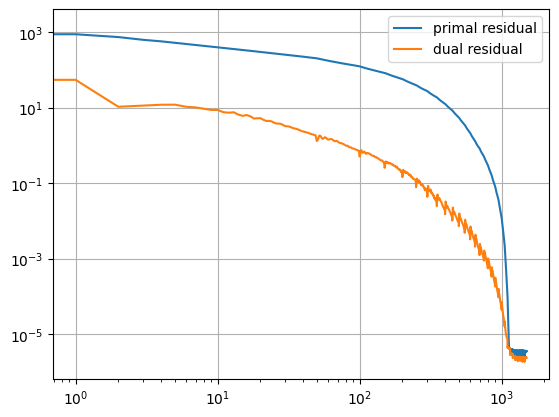

In [17]:
plt.loglog(history_admm.power, label="primal residual")
plt.loglog(history_admm.dual_power, label="dual residual")
plt.grid()
plt.legend()

In [18]:
solution_admm

ADMMState(num_terminals=tensor([[3.],
        [2.],
        [4.],
        ...,
        [3.],
        [9.],
        [4.]], device='cuda:0'), num_ac_terminals=tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0'), power=[[tensor([[0.0019],
        [0.0022],
        [0.0002],
        [0.0004],
        [0.0024],
        [0.0008],
        [0.0031],
        [0.0004],
        [0.0019]], device='cuda:0')], [tensor([[0.0016],
        [0.0009],
        [0.0034],
        [0.1803],
        [0.0035],
        [0.0004],
        [0.0004],
        [0.0004],
        [0.0009],
        [0.0011],
        [0.1753],
        [0.0031],
        [0.0034],
        [0.0031],
        [0.0018],
        [0.0031],
        [0.0003],
        [0.0004],
        [0.0009],
        [0.0032]], device='cuda:0'), tensor([[0.0016],
        [0.0009],
        [0.0034],
        [0.1803],
        [0.0035],
        [0.0004],
        [0.0004],
        [0.0004],
        [0.00

In [19]:
# Experiments with link failures

# Set link failure probability 

def resolve_post_fail(warm_start_admm, og_bridge_params, p_fail, eps=1e-8):
    ## Induce stochastic link failures
    new_capacities = og_bridge_params['capacities'].copy()
    rng = np.random.default_rng(42)
    fail_mask = rng.random(size=new_capacities.shape) < p_fail
    new_capacities[fail_mask] = eps
    new_bridge_params = og_bridge_params.copy()
    new_bridge_params['capacities'] = new_capacities

    grouping_params["variable_grouping_strategy"] = "discrete_terminal_groups"
    nu_opt_bridge = NUOptBridge(new_bridge_params, grouping_params)

    ## More intelligent warm-start by setting some flows to eps right away
    # R = new_bridge_params["R"]
    # col_nnz = R.sum(axis=0)
    # fail_link_idxs = np.argwhere(new_capacities == eps).ravel()
    # device_map = nu_opt_bridge.device_group_map_list
    # usage = R[fail_link_idxs, :].sum(axis=0).A1  # shape (n,)
    # dead = usage > 0 # boolean mask of length n

    # for group_idx, device_idxs in enumerate(device_map):
    #     # device_idxs is an array of global column indices in this group
    #     # check which of those are in `dead`
    #     local_dead_mask = dead[device_idxs]          # boolean mask length = len(device_idxs)
    #     if not np.any(local_dead_mask):
    #         continue

    #     local_dead_idxs = np.nonzero(local_dead_mask)[0]  # positions within this group
    #     warm_start_admm.power[group_idx][0][local_dead_idxs] = eps

    ## Do stuff to re-solve this with a warm start
    machine = "cuda"
    dtype = torch.float32
    admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in nu_opt_bridge.devices]
    admm = ADMMSolver(
        machine=machine,
        dtype=dtype,
        atol=1e-9,
        rtol=1e-9,
        tau=2,
        alpha=1.6,
        num_iterations=3000,
    )
    start_time = time.time()
    solution_admm, history_admm = admm.solve(
        nu_opt_bridge.net, 
        admm_devices, 
        nu_opt_bridge.time_horizon, 
        # initial_state = warm_start_admm
    )
    end_time = time.time()
    solve_time = end_time - start_time
    obj_val = solution_admm.objective


    return solution_admm, history_admm, solve_time


def resolve_post_fail_reduced(warm_start_admm, og_bridge_params, p_fail, eps=1e-12):
    ## Induce stochastic link failures
    new_capacities = og_bridge_params['capacities'].copy()
    rng = np.random.default_rng(42)
    fail_mask = rng.random(size=new_capacities.shape) < p_fail
    new_capacities[fail_mask] = eps


    # Just reduce the system by pruning dead links and flows
    R = og_bridge_params["R"]
    col_nnz = R.sum(axis=0)
    fail_link_idxs = np.argwhere(new_capacities == eps).ravel()
    usage = R[fail_link_idxs, :].sum(axis=0).A1  # shape (n,)
    dead = usage > 0 # boolean mask of length n

    survive_link_idxs = np.where(~fail_mask)[0]
    survive_flow_idxs = np.where(~dead)[0]

    # slice out the surviving rows then cols
    R_red = R[survive_link_idxs, :][:, survive_flow_idxs]
    capacities_red = og_bridge_params['capacities'][survive_link_idxs]
    w_red = og_bridge_params['w'][survive_flow_idxs]

    new_bridge_params = og_bridge_params.copy()
    new_bridge_params["R"] = R_red
    new_bridge_params["capacities"] = capacities_red
    new_bridge_params["w"] = w_red
    grouping_params["variable_grouping_strategy"] = "discrete_terminal_groups"
    nu_opt_bridge = NUOptBridge(og_bridge_params, grouping_params)
    device_map = nu_opt_bridge.device_group_map_list
    nu_opt_bridge = NUOptBridge(new_bridge_params, grouping_params)
    machine = "cuda"
    dtype = torch.float32
    admm_devices = [d.torchify(machine=machine, dtype=dtype) for d in nu_opt_bridge.devices]
    admm = ADMMSolver(
        machine=machine,
        dtype=dtype,
        atol=1e-9,
        rtol=1e-9,
        tau=2,
        alpha=1.6,
        num_iterations=1000,
    )
    warm_start_admm_red = admm.initialize_solver(
        nu_opt_bridge.net, 
        admm_devices, 
        nu_opt_bridge.time_horizon, 
        num_contingencies=0, 
        contingency_device=None,
)

    ## Try to come up with a warm-start point
    # for g, device_idxs in enumerate(device_map):
    #     # slice out only the surviving positions within this group
    #     local_survive = np.nonzero(np.isin(device_idxs, survive_flow_idxs))[0]
    #     # get the original tensor and slice it
    #     ## Power
    #     xg = warm_start_admm.power[g][0]        # torch.Tensor of shape (L,)
    #     # warm_start_admm_red.power[g][0] = xg[local_survive]

    #     ## Resid Power
    #     rg = warm_start_admm.resid_power[g][0]        # torch.Tensor of shape (L,)
    #     # warm_start_admm_red.resid_power[g][0] = rg[local_survive]

    #     ## Clone Power
    #     cg = warm_start_admm.clone_power[g][0]        # torch.Tensor of shape (L,)
    #     # warm_start_admm_red.clone_power[g][0] = cg[local_survive]

    #     ## Rho power
    #     # warm_start_admm_red.rho_power = warm_start_admm.rho_power


    # 3) prune slack flows
    ug = warm_start_admm.power[-1][0]    # torch.Tensor of shape (m,)
    # warm_start_admm_red.power[-1][0] = ug[survive_link_idxs]

    # warm_start_admm_red.dual_power = warm_start_admm.dual_power[survive_link_idxs]
    # warm_start_admm_red.avg_power = warm_start_admm.avg_power[survive_link_idxs]



    ## Do stuff to re-solve this with a warm start
    start_time = time.time()
    solution_admm, history_admm = admm.solve(
        nu_opt_bridge.net, 
        admm_devices, 
        nu_opt_bridge.time_horizon, 
        # initial_state=warm_start_admm_red,
    )
    end_time = time.time()
    solve_time = end_time - start_time
    obj_val = solution_admm.objective


    return solution_admm, history_admm, solve_time


In [22]:
p_fails = [0.01, 0.05, 0.1, 0.25, 0.35, 0.5] # a bunch of failure probabilities 
solve_times = []
sol_objs = []

warm_start_admm = solution_admm
og_bridge_params = nu_opt_params
for p_fail in p_fails:
    sol_admm, hist_admm, solve_time = resolve_post_fail_reduced(warm_start_admm, og_bridge_params, p_fail)
    sol_objs.append(sol_admm)
    solve_times.append(solve_time)




Did not converge. Ran for 1000 iterations.
Did not converge. Ran for 1000 iterations.
Did not converge. Ran for 1000 iterations.
Did not converge. Ran for 1000 iterations.
Did not converge. Ran for 1000 iterations.
Did not converge. Ran for 1000 iterations.


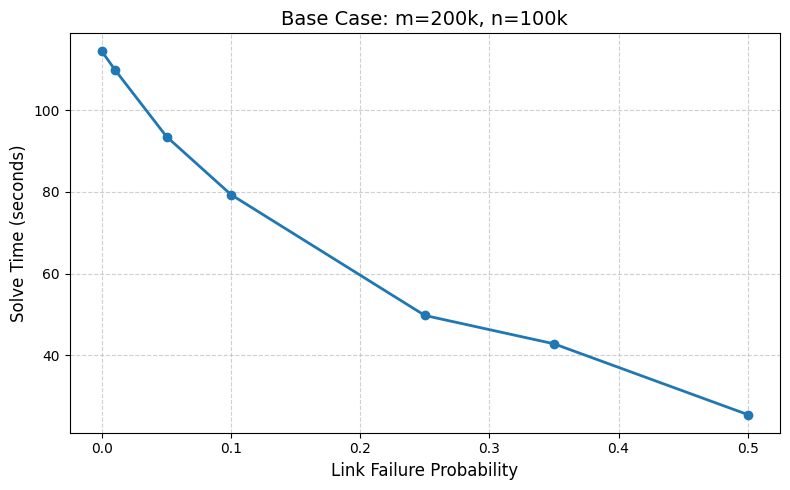

In [27]:
appended_p_fails = [0] + p_fails
appended_solve_times = [114.332] + solve_times
plt.figure(figsize=(8, 5))
plt.plot(appended_p_fails, appended_solve_times, marker='o', linewidth=2)

# Labels and Title
plt.xlabel("Link Failure Probability", fontsize=12)
plt.ylabel("Solve Time (seconds)", fontsize=12)
plt.title("Base Case: m=200k, n=100k", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

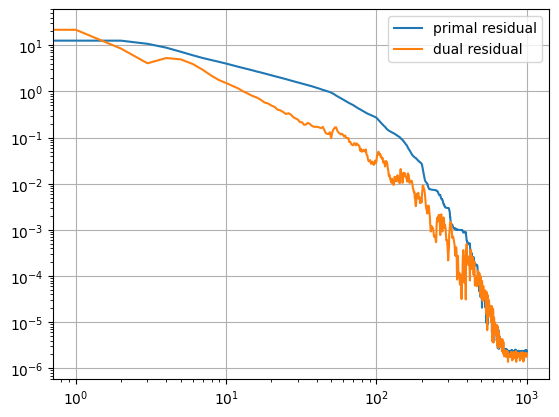

In [21]:
plt.loglog(hist_admm.power, label="primal residual")
plt.loglog(hist_admm.dual_power, label="dual residual")
plt.grid()
plt.legend()

In [98]:
eps=1e-12
new_capacities = og_bridge_params['capacities'].copy()
rng = np.random.default_rng(42)
fail_mask = rng.random(size=new_capacities.shape) < p_fail
new_capacities[fail_mask] = eps
new_bridge_params = og_bridge_params.copy()
new_bridge_params['capacities'] = new_capacities

R = og_bridge_params["R"]
col_nnz = R.sum(axis=0)
fail_link_idxs = np.argwhere(new_capacities == eps).ravel()
device_map = nu_opt_bridge.device_group_map_list
usage = R[fail_link_idxs, :].sum(axis=0).A1  # shape (n,)
dead = usage > 0 # boolean mask of length n

for group_idx, device_idxs in enumerate(device_map):
    # device_idxs is an array of global column indices in this group
    # check which of those are in `dead`
    local_dead_mask = dead[device_idxs]          # boolean mask length = len(device_idxs)
    if not np.any(local_dead_mask):
        continue

#     local_dead_idxs = np.nonzero(local_dead_mask)[0]  # positions within this group
#     warm_start_admm.power[group_idx][0][local_dead_idxs] = eps


array([False, False, False, ...,  True,  True,  True])

In [81]:
sol_admm.power[5][0][1:5]

tensor([[0.1208],
        [0.0811],
        [0.0908],
        [0.0525]], device='cuda:0')

In [49]:
np.argwhere(new_capacities == eps)

array([[    27],
       [    51],
       [    68],
       ...,
       [999977],
       [999992],
       [999993]])

In [48]:
sol_admm.dual_phase

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [81]:
solution_admm.rho_power

1048576.0

In [82]:
sol_admm.rho_power

512.0